In [ ]:
# Upload Input Data
# -----------------
# Parameters:

# Upload Input Data (True, False)
UPLOAD_DATA = False

# -----------------

if UPLOAD_DATA:
    from google.colab import files
    files.upload()

# -----------------

In [ ]:
# Modules Import
# --------------

import os
import enum
import json
from datetime import datetime

import numpy as np 
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --------------

In [ ]:
# Transfer Learning Available Base Models
# ---------------------------------------

class TL_MODEL(enum.Enum):
    NONE = False

    VGG16 = 'VGG16'
    INCEPTIONV3 = 'InceptionV3'
    RESNET50 = 'ResNet50'
    MOBILENETV2 = 'MobileNetV2'
    NASNETMOBILE = 'NASNetMobile'

# ---------------------------------------

In [ ]:
# Module Architecture Parameters
# ------------------------------
# Parameters:

# Image Height
IMG_H = 112

# Image Width
IMG_W = 112

# Resize with Padding (True, False)
IMAGE_PADDING = False

# Detect Faces (True, False)
DETECT_FACES = True

# Transfer Learning (Value in TL_MODEL)
TRANSFER_LEARNING = TL_MODEL.VGG16.value

# Model Architecture (1, 2, 3)
N_MODEL = 3

# Batch Size
BATCH_SIZE = 100

# Train Model (True, False)
TRAIN_MODEL = True

# ------------------------------

In [ ]:
# Define Directories
# ------------------
# Parameters:

# Root Directory
ROOT_DIR = '/content/image_classification'

# ------------------

input_dir = '%s/input' % ROOT_DIR
output_dir = '%s/working' % ROOT_DIR

train_gt = '%s/train_gt.json' % input_dir
training_dir = '%s/training' % input_dir
test_dir = '%s/test' % input_dir

train_faces_gt = '%s/train_faces_gt.json' % output_dir
training_faces_dir = '%s/training_faces' % output_dir
training_padding_dir = '%s/training_padding' % output_dir

model_path = '%s/model.h5py' % output_dir

if not os.path.exists(ROOT_DIR):
    !unzip /content/image_classification.zip

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ------------------

In [ ]:
# Random Seed
# -----------
# Parameters:

# Random Seed
SEED = 1000

# -----------

tf.random.set_seed(SEED) 

# -----------

In [ ]:
# Load Dataframe
# --------------

with open(train_gt) as f:
  dic = json.load(f)

df3 = pd.DataFrame(dic.items())
df3.rename(columns = {0:'filename', 1:'class'}, inplace = True)

# --------------

In [ ]:
# Auxiliary Functions
# --------------------------------

def setup_retina_face():
    !pip install retinaface --quiet
    from retinaface import RetinaFace

    return RetinaFace(quality="normal")

def show_stats(i, every):
    global start_time

    if i == 0:
        start_time = datetime.now()
    if i != 0 and i % every == 0:
        end_time = datetime.now()
        print('%s: %s' % (i, end_time - start_time))
        start_time = end_time

def load_image(file_name, test):
    file_path = '%s/%s' % (test_dir if test else training_dir, file_name)

    rgb_img = Image.open(file_path).convert('RGB')

    return rgb_img

def crop_image(pixels, face):
    h, w, _ = pixels.shape

    x1, x2 = face['x1'], face['x2']
    y1, y2 = face['y1'], face['y2']
    x1, x2, y1, y2 = max(x1, 0), min(x2, w), max(0, y1), min(y2, h)
    
    return pixels[y1:y2, x1:x2]

def make_square(pixels):
    x, y = pixels.size
    size = max(IMG_H, x, y)

    new_img = Image.new('RGB', (size, size), (0, 0, 0, 0))
    new_img.paste(pixels, (int((size - x) / 2), int((size - y) / 2)))

    return new_img

def save_image(pixels, file_name, i):
    new_file_name = file_name.split('.')[0] + '_' + str(i) + '.jpg'
    new_file_path = '%s/%s' % (training_faces_dir, new_file_name)

    new_img = make_square(pixels) if IMAGE_PADDING else pixels
    new_img.save(new_file_path)

    return new_file_name

# --------------------------------

In [ ]:
# Image Padding 
# ------------

if IMAGE_PADDING and not DETECT_FACES and not os.path.exists(training_padding_dir):
    os.makedirs(training_padding_dir)

    for row_index, row in df3.iterrows():
        show_stats(row_index, every=100)

        file_path = '%s/%s' % (training_dir, row['filename'])
        new_file_path = '%s/%s' % (training_padding_dir, row['filename'])

        rgb_img = Image.open(file_path).convert('RGB')
        rgb_img = make_square(rgb_img)

        rgb_img.save(new_file_path)

# ------------

In [ ]:
# Detect Faces
# ------------
# Parameters:

# Force Reload Images (True, False)
FORCE_RELOAD = False

# ------------

if DETECT_FACES:
    if not os.path.exists(training_faces_dir):
        os.makedirs(training_faces_dir)
        
    detector = setup_retina_face()

    if os.path.isfile(train_faces_gt) and not FORCE_RELOAD:
        # Load Processed Images Dataframe
        df2 = pd.read_json(train_faces_gt)
    else:
        data = []
        for row_index, row in df3.loc[(df3['class'] == 0) | (df3['class'] == 1)].iterrows():
            show_stats(row_index, every=100)

            # Load Image to Process
            rgb_img = load_image(row['filename'], test=False)
            pixels = np.asarray(rgb_img)

            # Process Image
            faces = detector.predict(pixels)

            for index, face in enumerate(faces):              
                # Crop Processed Image  
                pixels_cropped = crop_image(pixels, face)
                rgb_img_cropped = Image.fromarray(pixels_cropped)

                # Save Processed Image
                new_file_name = save_image(rgb_img_cropped, row['filename'], index)
                data.append([new_file_name, 'mask' if row['class'] == 1 else 'no_mask'])

        # Save Processed Images Dataframe
        df2 = pd.DataFrame(data, columns=['filename', 'class'])
        df2.to_json(train_faces_gt)
else:
    # Cast Labels to 'str' for Categorical Class Mode
    df3['class'] = df3['class'].astype(str)

# ------------

model[normal quality] init ..
model success !


In [ ]:
# Dataframe Splitting
# -------------------
# Parameters:

# Dataframe Split
DF_SPLIT = 0.8

# -------------------

DATAFRAME = df2 if DETECT_FACES else df3

probs = np.random.rand(len(DATAFRAME))
training_mask = probs < DF_SPLIT
validation_mask = (probs >= DF_SPLIT)

DF_TRAIN = DATAFRAME[training_mask]
DF_VAL = DATAFRAME[validation_mask]

# -------------------

In [ ]:
# Data Augmentation
# -----------------
# Parameters:

# Apply Data Augementation (True, False)
APPLY_DATA_AUGMENTATION = True

# Data Augmentation Parameters
WIDTH_SHIFT_RANGE = 10
HEIGHT_SHIFT_RANGE = 10
ROTATION_RANGE = 10
SHEAR_RANGE = 0.1
ZOOM_RANGE = 0.1
CHANNEL_SHIFT_RANGE = 0.1
HORIZONTAL_FLIP = True
VERTICAL_FLIP = False
FILL_MODE = 'constant'
RESCALE = 1./255

# -----------------

# Training Data Image Generator
if APPLY_DATA_AUGMENTATION:
    train_data_gen = ImageDataGenerator(width_shift_range=WIDTH_SHIFT_RANGE,
                                        height_shift_range=HEIGHT_SHIFT_RANGE,
                                        rotation_range=ROTATION_RANGE,
                                        shear_range=SHEAR_RANGE,
                                        zoom_range=ZOOM_RANGE,
                                        channel_shift_range=CHANNEL_SHIFT_RANGE,
                                        horizontal_flip=HORIZONTAL_FLIP,
                                        vertical_flip=VERTICAL_FLIP,
                                        fill_mode=FILL_MODE,
                                        rescale=RESCALE)
else:
    train_data_gen = ImageDataGenerator(rescale=RESCALE)

# Validation Data Image Generator
val_data_gen = ImageDataGenerator(rescale=RESCALE)

# -----------------

In [ ]:
# Data Generator
# --------------

NUM_CLASSES = 2 if DETECT_FACES else 3

IMG_SHAPE = (IMG_H, IMG_W) + (3,)

if DETECT_FACES:
    DF_DIR = training_faces_dir 
    CLASS_MODE = 'binary'
    CLASSES = ['no_mask',
              'mask']
else:
    DF_DIR = training_padding_dir if IMAGE_PADDING else training_dir
    CLASS_MODE = 'categorical'
    CLASSES = None

# Training Data Generator
train_gen = train_data_gen.flow_from_dataframe(DF_TRAIN,
                                               DF_DIR,
                                               batch_size=BATCH_SIZE,
                                               target_size=(IMG_H, IMG_W),
                                               class_mode=CLASS_MODE,
                                               classes=CLASSES,
                                               shuffle=True,
                                               seed=SEED)

# Validation Data Generator
val_gen = val_data_gen.flow_from_dataframe(DF_VAL,
                                           DF_DIR,
                                           batch_size=BATCH_SIZE,
                                           target_size=(IMG_H, IMG_W),
                                           class_mode=CLASS_MODE,
                                           classes=CLASSES,
                                           shuffle=True,
                                           seed=SEED)

# --------------

Found 10718 validated image filenames belonging to 2 classes.
Found 2729 validated image filenames belonging to 2 classes.


In [ ]:
# Dataset Loader
# --------------

OUTPUT_SHAPE = [None] if NUM_CLASSES == 2 else [None, 3]

# Training Dataset
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, IMG_H, IMG_W, 3], OUTPUT_SHAPE))

# Repeat Training Dataset
train_dataset = train_dataset.repeat()

# Validation Dataset
val_dataset = tf.data.Dataset.from_generator(lambda: val_gen, 
                                             output_types=(tf.float32, tf.float32),
                                             output_shapes=([None, IMG_H, IMG_W, 3], OUTPUT_SHAPE))

# Repeat Validation Dataset
val_dataset = val_dataset.repeat()

# --------------

In [ ]:
# Model Architecture Setup
# ------------------------ 

OUTPUT_UNITS = 1 if NUM_CLASSES == 2 else NUM_CLASSES
C_ACTIVATION = 'sigmoid' if NUM_CLASSES == 2 else 'softmax'

if TRANSFER_LEARNING:
    BASE_MODEL = getattr(tf.keras.applications, TRANSFER_LEARNING)(
        include_top=False,
        weights="imagenet",
        input_shape=IMG_SHAPE,
        classes=NUM_CLASSES
    )

    BASE_MODEL.trainable = False

    BASE_MODEL.summary()

# ------------------------

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 28, 28, 128)       0     

In [ ]:
# Model Architecture 1
# --------------------

if N_MODEL == 1:
    if TRANSFER_LEARNING:
        raise Exception('Not available for Transfer Learning.')
    else:
        START_F = 8
        DEPTH = 5

        MODEL = tf.keras.Sequential()

        for i in range(DEPTH):
            if i == 0:
                INPUT_SHAPE = IMG_SHAPE
            else:
                INPUT_SHAPE = [None]

            MODEL.add(tf.keras.layers.Conv2D(filters=START_F, 
                                             kernel_size=(3, 3),
                                             strides=(1, 1),
                                             padding='same',
                                             input_shape=INPUT_SHAPE))
            MODEL.add(tf.keras.layers.ReLU())
            MODEL.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

            START_F *= 2
            
        MODEL.add(tf.keras.layers.Flatten())
        MODEL.add(tf.keras.layers.Dense(units=512, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
        MODEL.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=C_ACTIVATION))

# --------------------

In [ ]:
# Model Architecture 2
# --------------------

if N_MODEL == 2:    
    if TRANSFER_LEARNING:
        MODEL = tf.keras.Sequential()
        MODEL.add(BASE_MODEL)

        MODEL.add(tf.keras.layers.Flatten())
        MODEL.add(tf.keras.layers.Dense(256, activation=tf.keras.layers.ReLU(), input_dim=IMG_SHAPE))
        MODEL.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=C_ACTIVATION))
    else:
        raise Exception('Available only for Transfer Learning.')

# --------------------

In [ ]:
# Model Architecture 3
# --------------------

if N_MODEL == 3:    
    if TRANSFER_LEARNING == TL_MODEL.VGG16.value:
        MODEL = tf.keras.Sequential()
        MODEL.add(BASE_MODEL)

        MODEL.add(tf.keras.layers.Flatten())
        MODEL.add(tf.keras.layers.Dense(128, activation=tf.keras.layers.ReLU(), input_dim=IMG_SHAPE))
        MODEL.add(tf.keras.layers.Dense(units=OUTPUT_UNITS, activation=C_ACTIVATION))

        BASE_MODEL.trainable = True

        for layer in BASE_MODEL.layers:
            if layer.name in ['block5_conv1', 'block4_conv1']:
                layer.trainable = True
            else:
                layer.trainable = False

    else:
        raise Exception('Available only for VGG16.')

# --------------------

In [ ]:
# Model Summary
# -------------

MODEL.summary()

# -------------

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               589952    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 15,304,769
Trainable params: 4,130,049
Non-trainable params: 11,174,720
_________________________________________________________________


In [ ]:
# Model Optimization
# ------------------
# Parameters:

# Early Stopping (True, False)
EARLY_STOP = True

# Learning Rate 
LR = 1e-5

# Validation Metrics
METRICS = ['accuracy']

# ------------------

callbacks = []

if EARLY_STOP:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    callbacks.append(es_callback)

# Loss Function
if DETECT_FACES:
    LOSS = tf.keras.losses.BinaryCrossentropy()
else:
    LOSS = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

# Compile Model
MODEL.compile(optimizer=optimizer, loss=LOSS, metrics=METRICS)

# ------------------

In [ ]:
# Model Fitting
# -------------
# Parameters:

# Number of Epochs
EPOCHS = 20

# -------------

if TRAIN_MODEL:
    history = MODEL.fit(x=train_dataset,
                        epochs=EPOCHS,
                        steps_per_epoch=len(train_gen),
                        validation_data=val_dataset,
                        validation_steps=len(val_gen), 
                        callbacks=callbacks)
    MODEL.save(model_path)

    final_accuracy = history.history["val_accuracy"][-5:]
    print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))
else:
    MODEL = load_model(model_path)

# -------------

Train for 108 steps, validate for 28 steps
Epoch 1/20
108/108 [==============================] - 41s 376ms/step - loss: 0.2588 - accuracy: 0.9171 - val_loss: 0.0627 - val_accuracy: 0.9798
Epoch 2/20
108/108 [==============================] - 39s 358ms/step - loss: 0.0465 - accuracy: 0.9872 - val_loss: 0.0579 - val_accuracy: 0.9813
Epoch 3/20
108/108 [==============================] - 39s 359ms/step - loss: 0.0352 - accuracy: 0.9905 - val_loss: 0.0393 - val_accuracy: 0.9868
Epoch 4/20
108/108 [==============================] - 39s 357ms/step - loss: 0.0297 - accuracy: 0.9921 - val_loss: 0.0323 - val_accuracy: 0.9897
Epoch 5/20
108/108 [==============================] - 38s 356ms/step - loss: 0.0272 - accuracy: 0.9928 - val_loss: 0.0455 - val_accuracy: 0.9857
Epoch 6/20
108/108 [==============================] - 38s 356ms/step - loss: 0.0250 - accuracy: 0.9938 - val_loss: 0.0413 - val_accuracy: 0.9857
Epoch 7/20
108/108 [==============================] - 38s 356ms/step - loss: 0.0238 - a

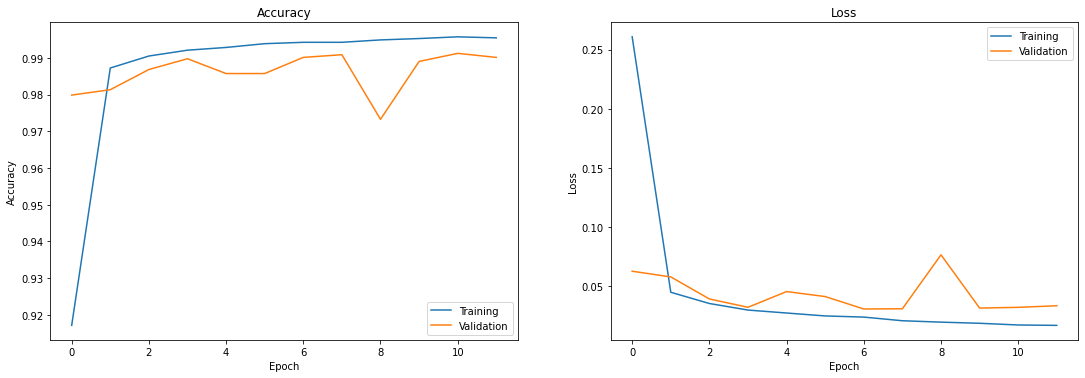

In [ ]:
# Display Loss and Accuracy
# -------------------------

def display_training_curves(training, validation, title, subplot):
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend(['Training', 'Validation'])


if TRAIN_MODEL:
    plt.subplots(figsize=(15,5))
    plt.tight_layout()

    display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'Accuracy', 121)
    display_training_curves(history.history['loss'], history.history['val_loss'], 'Loss', 122)

# -------------------------

In [ ]:
# Prediction Auxiliary Functions
# ------------------------------

def create_csv(results):
    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open('%s/%s' % (output_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

def plot_pred(i, every):
    if i != 0 and i % every == 0:
        plt.figure()
        plt.imshow(pixels)
        plt.xlabel(faces_pred if DETECT_FACES else pred, fontsize=30)
        plt.show()

def prepare_input(rgb_img):
    input = rgb_img.resize((IMG_H, IMG_W), Image.ANTIALIAS)
    input = make_square(input) if IMAGE_PADDING else input
    input = image.img_to_array(input) / 255.0
    input = np.expand_dims(input, axis=0)

    return input

# ------------------------------

In [ ]:
# Model Evaluation
# ----------------
# Parameters:

# Plot Predictions (True, False)
PLOT_PRED = False

# ----------------

results = {}
image_filenames = next(os.walk(test_dir))[2]

for row_index, image_name in enumerate(image_filenames):   
    show_stats(row_index, every=10)
    if PLOT_PRED:
        plot_pred(row_index, every=100)

    # Load Image to Process
    rgb_img = load_image(image_name, test=True)
    pixels = np.asarray(rgb_img)

    if DETECT_FACES:
        # Preprocess Image
        faces = detector.predict(pixels)

        faces_pred = []
        for index, face in enumerate(faces):              
            # Data Preparation
            pixels_cropped = crop_image(pixels, face)
            face_test = prepare_input(Image.fromarray(pixels_cropped))
            
            # Predict
            face_pred = MODEL.predict(face_test)
            face_pred = 1 if face_pred < 0.5 else 0
            faces_pred.append(face_pred)

        # Detect Faces Prediction
        pred = 0 if sum(faces_pred) == 0 else 1 if sum(faces_pred) == len(faces_pred) else 2

    else:
        # Data Preparation
        image_test = prepare_input(rgb_img)

        # Predict
        softmax = MODEL.predict(image_test)
        pred = np.argmax(softmax)

    results[image_name] = pred

create_csv(results)

# ----------------

10: 0:00:02.039226
20: 0:00:01.606500
30: 0:00:01.580741
40: 0:00:01.145802
50: 0:00:01.853746
60: 0:00:01.287661
70: 0:00:01.305056
80: 0:00:01.070991
90: 0:00:01.392701
100: 0:00:01.336218
110: 0:00:01.288969
120: 0:00:00.960623
130: 0:00:01.148699
140: 0:00:01.410064
150: 0:00:01.047291
160: 0:00:01.560203
170: 0:00:01.066677
180: 0:00:01.059004
190: 0:00:01.085553
200: 0:00:01.326116
210: 0:00:01.033919
220: 0:00:01.181927
230: 0:00:01.209611
240: 0:00:01.601470
250: 0:00:01.113798
260: 0:00:00.983673
270: 0:00:01.185161
280: 0:00:01.063120
290: 0:00:01.134141
300: 0:00:01.395806
310: 0:00:01.176852
320: 0:00:01.253299
330: 0:00:01.098067
340: 0:00:01.085720
350: 0:00:01.391575
360: 0:00:01.118974
370: 0:00:01.068747
380: 0:00:01.308099
390: 0:00:01.269455
400: 0:00:01.020947
410: 0:00:00.991910
420: 0:00:01.126772
430: 0:00:01.162631
440: 0:00:01.051880


In [ ]:
# Check Differences
# -----------------

with open('%s/%s' % (output_dir, 'best_submission.csv')) as f:
    csv = f.readlines()

for key, value in results.items():
    line = (key + ',' + str(value) + '\n')

    if line not in csv:
        print(line)

        file_path = '%s/%s' % (test_dir, key)
        rgb_img = Image.open(file_path).convert('RGB')

        plt.figure()
        plt.imshow(rgb_img)
        plt.show()

# -----------------